<a href="https://colab.research.google.com/github/RajivChitale/Machine-Learning/blob/main/RL/3-RL-Concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reinforcement Learning**
- Reinforcement learning is an area of machine learning which uses feedback data to learn.
- It consists of an agent which interacts with an environment.
- The agent takes actions and is rewarded accordingly by the environment.
- An important aspect of reinforcement learning is that it is time-based and the data is sequential.

# Markov Decision Process
- Reinforcement learning problems can be modelled using Markov Decision Processes or MDPs.

<img src='https://ml-lectures.org/_images/mdp.png'>

- MDPs are a 5-tuple $(S, A, P_a, R_a, \gamma)$
  - $S$: set of all states
  - $A$: set of all actions
  - $P_a(s,s')$: probabilty of state transition from s to s' after action a
  - $R_a(s,s')$: reward for an action a, obtained during transition from s to s'
  - $\gamma$: discount factor
- *State* is the information regarding the environment that the agent has.   
e.g. location, velocity
- *Actions* are undertaken by the agent to interact with the environment  
e.g. walking in a direction or shooting a laser
- *Transitions* occur at every *timestep*. The next state is based on the actions.  
e.g. moving to adjacent cell
- *Rewards* are given to the agent based on the action taken. These maybe positive or negative.   
e.g. positive reward for winning, negative reward for getting damage

- The Markov Property is an important property of MDPs. It implies that the next state depends on only the current state and not on the previous states.
$ P(S_n=s_n | S_{n-1}=s_{n-1}, \dots, S_0=s_0) = P(S_n=s_n | S_{n-1}=s_{n-1})$

- After defining a problem in this way, we try to find the best policy $\pi$ which results in maximum sum of rewards.

- A common method is to estimate the value of each state or state-action pair in terms of the expected reward.

Note: The set of states and actions can be infinite. MDPs have discrete values for states and actions but many problems have continuous domain of values.  Either they have to be discretized or another method such as policy gradients has to be used.


# Bellman Expectation Equation and Discount Factor

- The state-action value $q_{\pi}$ can be broken down as the sum of expected immediate reward $R_{t+1}$ from current action and the expected value of future rewards from the next state.

- $q_{\pi}(s,a) = \mathbb{E}[R_{t+1} + \gamma q_{\pi}(S_{t+1},A_{t+1}) | S_t =s, A_t =a] $

- The discount factor $\gamma$ is a value between 0 and 1.
  - A value closer to 0 gives weightage to immediate rewards.
  - A value closer to 1 gives weightage to long term rewards.
  - This factor also ensures that the values converge to a finite value.

# Analysis of Q-Learning and SARSA



- *Q-Learning* and *SARSA (State-Action-Reward-State-Action)* are two algorithms based on the concept of *Dynamic Programming* (DP).
- They maintain a table of state-action values (denoted by $Q$). These are updated every iteration.
- They choose an action using epsilon-greedy approach, which balances exploration and exploitation.
- At each step they calculate the expected reward of an action, and its difference with Q.
- They adjust Q to reduce this difference, with a learning rate of $\alpha$.  

- Their difference lies in how the expected value is calculated using existing Q value estimates. The differences are explored later, with support of observations.


## Cliff Walking

We will run the two algorithms on this environment.

- This consists of a 2D grid of discrete states. The lowest row is a cliff.
- The agent receives a reward of -100 when it falls into the cliff.
- In other cases it receives a reward of -1 (incentive for hurrying up).
- Starting position is bottom left tile and end position is bottom right tile.
- The agent is send to start position after falling into the cliff.


![cliff env](https://www.gymlibrary.dev/_images/cliff_walking.gif)

In [268]:
import numpy as np
#!pip install ray[rllib]
# !pip install --upgrade ipykernel
import gymnasium as gym
from matplotlib import pyplot as plt


In [ ]:
env = gym.make('CliffWalking-v0')

height = 4
width = 12
num_actions = 4

### 1. Q-Learning

In [253]:
def QL(episode_count = 41, alpha = 0.7, discount = 0.95, epsilon = 0.02):
    Q = np.zeros((height*width, num_actions), 'float')  # initialize with 0 (or random values if it gets stuck at start)
    # Q[0:36,:] -= np.random.rand( (height-1)*width*num_actions ).reshape( (height-1)*width, num_actions) )

    episode_nums=[]
    episode_rewards=[]
    episode_steps=[]
    episode_falls=[]
    fall_count=0
    reward_sum=0
    steps_count=0
    gap = episode_count//20

    pos, info = env.reset()
    # print(pos)

    for episode in range(episode_count):
        if(episode%gap == 0 and episode >0):
            #print("Finished Episode", episode)
            epsilon *= 0.95                             # reduce exploration
            episode_rewards.append(round(reward_sum/gap, 2))
            episode_steps.append(round(steps_count/gap, 2))                 # gathering data
            episode_nums.append(episode)
            episode_falls.append(round(fall_count/gap, 2))
            reward_sum = 0
            fall_count=0
            steps_count=0

        pos, info = env.reset()

        for steps in range(1000):                       # truncate if stuck
            # epsilon-greedy choice of action:
            if(np.random.uniform(0,1) < epsilon):
                action = np.random.randint(0,num_actions)       # explore randomly
            else:
                action = np.argmax(Q[pos, :])        # exploit best action

            obs, reward, terminated, truncated, info = env.step(action) # take action, get reward and next state
            # print(obs//12, obs%12)

            if(reward==-100):
              fall_count+= 1
              # i, j=pos//12, pos%12
              # print("Fell from ", (i,j))

            reward_sum += reward

            if terminated or truncated: break

            # Update Q value. The next value Q' is based on exploitation of best action
            Q[pos, action] += alpha * (discount*np.max(Q[obs,:]) + reward -Q[pos, action])

            pos = obs     # update state to new one

        steps_count += steps

    return [Q, episode_nums, episode_rewards, episode_steps, episode_falls]

In [261]:
QL_Q, QL_episodes, QL_rewards, QL_steps, QL_falls = QL()
print("Rewards/Episode:", QL_rewards)
print("Steps/Episode:  ", QL_steps)
print("Falls/Episode:  ", QL_falls)
print()
print("Final Policy  (0=Up, 1=Right, 2=Down, 3=Left)")
print(np.argmax(QL_Q, axis=1).reshape((4,12)))

Rewards/Episode: [-154.5, -743.0, -113.5, -54.5, -101.5, -158.0, -40.5, -27.0, -28.5, -21.0, -25.0, -30.5, -15.5, -19.0, -85.5, -17.0, -26.0, -14.0, -14.0, -14.5]
Steps/Episode:   [104.0, 197.5, 63.0, 53.5, 51.0, 58.0, 39.5, 26.0, 27.5, 20.0, 24.0, 29.5, 14.5, 18.0, 35.0, 16.0, 25.0, 13.0, 13.0, 13.5]
Falls/Episode:   [0.5, 5.5, 0.5, 0.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]

Final Policy  (0=Up, 1=Right, 2=Down, 3=Left)
[[1 1 1 1 1 3 3 1 2 2 0 2]
 [1 1 1 1 1 1 2 1 2 2 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [379]:
# Running Q Learning
total_reward = 0

pos, info = env.reset()

for steps in range(500):                       # truncate if stuck
    env.render()
    # epsilon-greedy choice of action:
    action = np.argmax(QL_Q[pos, :])        # exploit best action

    pos, reward, terminated, truncated, info = env.step(action) # take action, get reward and next state
    # print(obs//12, obs%12)
    total_reward += reward
    i, j=pos//12, pos%12
    #print(i,j)

    if terminated or truncated:
        break

print("Reward in run test", total_reward)

Reward in run test -13


### 2. Expected SARSA



In [256]:
def SARSA(episode_count = 41, alpha=0.7, discount=0.95, epsilon=0.02):
    Q = np.zeros((height*width, num_actions), 'float')  # initialize Q table
    # print(Q)

    episode_nums=[]
    episode_rewards=[]
    episode_steps=[]
    episode_falls=[]
    steps_count=0
    fall_count=0
    reward_sum=0
    gap = episode_count//20

    pos, info = env.reset()
    # print(pos)

    for episode in range(episode_count):
        if(episode%gap == 0 and episode >0):
            #print("Finished Episode", episode)
            epsilon *= 0.95                             # reduce exploration
            episode_rewards.append(round(reward_sum/gap,2))
            episode_steps.append(steps)                 # gathering data
            episode_nums.append(episode)
            episode_falls.append(round(fall_count/gap, 2))
            reward_sum = 0
            fall_count=0
            steps_count=0

        pos, info = env.reset()

        for steps in range(1000):                       # truncate if stuck
            # epsilon-greedy choice of action:
            if(np.random.uniform(0,1) < epsilon):
                action = np.random.randint(0,num_actions)       # explore randomly
            else:
                action = np.argmax(Q[pos, :])        # exploit best action

            obs, reward, terminated, truncated, info = env.step(action) # take action, get reward and next state
            # print(obs//12, obs%12)

            reward_sum += reward

            if(reward==-100):
              fall_count+= 1
              # i, j=pos//12, pos%12
              # print("Fell from ", (i,j))

            if terminated or truncated: break

            # update Q values for Q learning
            future_rewards = np.max(Q[obs,:]) * (1-epsilon) + np.average(Q[obs,:]) * epsilon        # on policy
            Q[pos, action] += alpha * (discount*future_rewards) + reward -Q[pos, action]


            # update state to new one
            pos = obs

        steps_count+=steps

    return [Q, episode_nums, episode_rewards, episode_steps, episode_falls]


In [262]:
SARSA_Q, SARSA_episodes, SARSA_rewards, SARSA_steps, SARSA_falls = SARSA()
print("Rewards/Episode:", SARSA_rewards)
print("Steps/Episode:  ", SARSA_steps)
print("Falls/Episode:  ", SARSA_falls)
print()
print("Final Policy  (0=Up, 1=Right, 2=Down, 3=Left)")
print(np.argmax(SARSA_Q, axis=1).reshape((4,12)))

Rewards/Episode: [-229.0, -560.0, -37.5, -49.0, -34.5, -33.5, -29.0, -34.0, -25.5, -24.5, -20.0, -17.0, -16.5, -17.5, -19.0, -15.0, -15.0, -15.0, -15.0, -16.0]
Steps/Episode:   [54, 50, 32, 65, 32, 40, 28, 25, 23, 21, 15, 18, 17, 17, 14, 14, 14, 14, 14, 14]
Falls/Episode:   [1.5, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Final Policy  (0=Up, 1=Right, 2=Down, 3=Left)
[[1 1 1 1 2 1 1 1 0 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 1 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [380]:
# Running SARSA
total_reward = 0
pos, info = env.reset()

for steps in range(500):                       # truncate if stuck
    # epsilon-greedy choice of action:
    action = np.argmax(SARSA_Q[pos, :])        # exploit best action

    pos, reward, terminated, truncated, info = env.step(action) # take action, get reward and next state
    # print(obs//12, obs%12)
    total_reward += reward
    i, j=pos//12, pos%12
    #print(i,j)

    if terminated or truncated:
        break

print("Average reward in run test", total_reward)

Average reward in run test -15


### Observations
Training
- Q-Learning estimates future rewards based on the best action which is *off-policy*.  
SARSA estimates future rewards based on episilon greedy policy which is *on-policy*.  
Expected SARSA variant used here takes the expected value from all actions based on the same policy.

- The agent in Q Learning does not consider the small chance of falling down the cliff  
in the next state during exploration. These result in falls during training. Refer graph (c).  
- SARSA considers the small chance of falling into the cliff in the next state.  
Hence it avoids going along the cliffside. It is a safer option in training.

- Q Learning is slower to train than SARSA. Refer graph (b) where Q-Learning lags.

Testing
- Q-Learning provides better final policy than SARSA.
- Q-Learning achieved reward of -13 in the test run. SARSA achieved -15.
- The final policy of Q learning contains the shortest route along the cliffside.
- SARSA took 2 steps more as it went one row further, avoiding the cliffside.

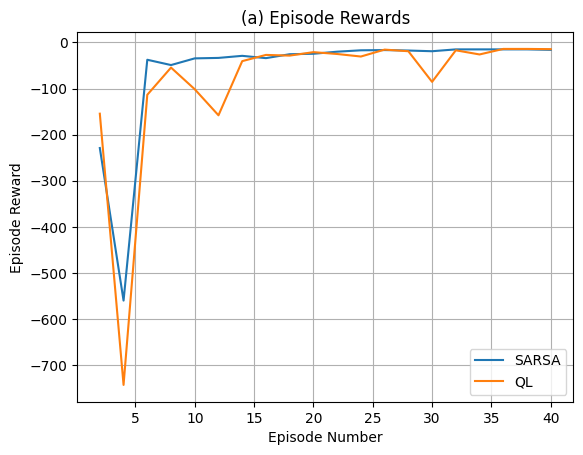

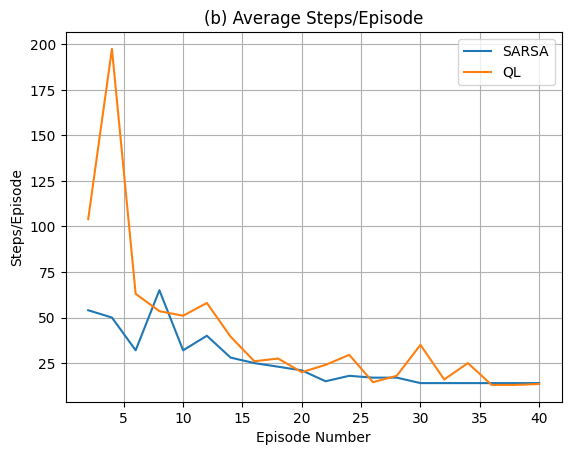

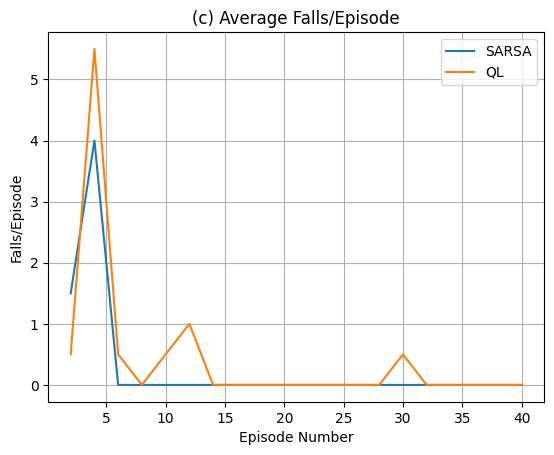

In [351]:
# Plotting QL and SARSA
plt.plot(SARSA_episodes, SARSA_rewards, label='SARSA')
plt.plot(QL_episodes, QL_rewards, label='QL')
plt.title("(a) Episode Rewards")
plt.ylabel("Episode Reward")
plt.xlabel("Episode Number")
plt.grid()
plt.legend()
plt.show()

plt.plot(SARSA_episodes, SARSA_steps, label='SARSA')
plt.plot(QL_episodes, QL_steps, label='QL')
plt.title("(b) Average Steps/Episode")
plt.ylabel("Steps/Episode")
plt.xlabel("Episode Number")
plt.grid()
plt.legend()
plt.show()

plt.plot(SARSA_episodes, SARSA_falls, label='SARSA')
plt.plot(QL_episodes, QL_falls, label='QL')
plt.title("(c) Average Falls/Episode")
plt.xlabel("Episode Number")
plt.ylabel("Falls/Episode")
plt.grid()
plt.legend()
plt.show()


# Differences in DP and Monte Carlo methods


### 3. Monte Carlo Simulation
- This experiment demonstrates a Monte Carlo simulation.
- It runs simulations with random actions to obtain values for states.
- This implementation uses the Every-Visit variant. This rewards a state on every visit, possibly multiple times in an episode.

In [358]:
def MonteCarlo(num_episodes = 201, step_limit= 2500):
    V = np.zeros((height*width), 'float')   # cumulative reward earned by state
    N = np.zeros((height*width), 'float')   # total visits to a state   (note: careful with N=0 later)

    def episode_result(S, R, steps):
        future_reward = 0
        for i in range(steps-1, -1, -1):
            future_reward += R[i]
            V[S[i]] += float(future_reward)/(steps-i)
            N[S[i]] += 1

    for episode in range(num_episodes):
        pos, info = env.reset()
        states = np.zeros( (step_limit), 'int') # store visited states in an episode
        rewards = np.zeros( (step_limit), 'float') # store rewards in an episode

        for step in range(step_limit):
            states[step] = pos                      # note down state
            action = np.random.randint(4)           # take random action
            pos, reward, terminated, truncated, info = env.step(action)   # take action, get reward and next state
            rewards[step] = reward                  # note down action
            if terminated or truncated: break

        episode_result(states, rewards, step)

    N[N==0] = 1                   # where N and V are 0, avoid divide by 0
    V = (V/N).reshape((4,12))
    V[V==0] = np.min(V)
    return V


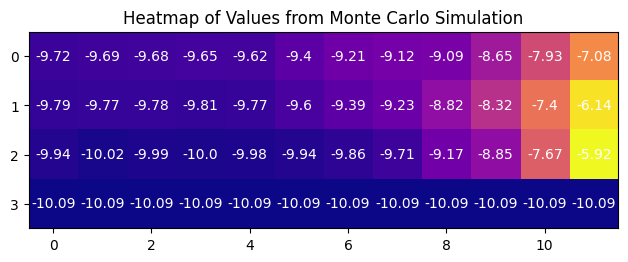

In [372]:
MC_V = MonteCarlo().round(2)

def heatmap(V):
    fig, ax = plt.subplots()
    im = ax.imshow(V, interpolation='none', cmap='plasma')

    for i in range(4):
        for j in range(12):
            text = ax.text(j, i, V[i, j], ha="center", va="center", color="w")

    ax.set_title("Heatmap of Values from Monte Carlo Simulation")
    fig.tight_layout()
    plt.show()
    #print(V)

heatmap(MC_V)

## Observed Differences in Methods

<font size=4> DP Methods </font> | <font size=4>  Monte Carlo Methods
------------- | -------------
<font size=3>  *Model-based*: require knowledge of states and actions  | <font size=3>  *Model-free*: need only experience to learn
<font size=3>  Assign rewards and update values every transition  | <font size=3> Assign rewards at the end of each episode
<font size=3>  *Bootstrapping*: use estimates to calculate new estimate values   | <font size=3>  Calculate values of states independent of other states or estimates  
<font size=3> Balance *exploration* and *exploitation* with the episilon-greedy technique |<font size=3> Explore randomly without exploiting best choice


# Value Based vs Policy Based
- In value based learning, the state value $V$ or state-action value $Q$ are calculated and stored.   
The policy is implicit and derived from the values- choose the action which results in state with greatest value.   
e.g. SARSA

- In policy based learning, the policy $\pi$ is calculated and stored, but state values are not.   
It maintains actions to be taken from a state, or their probabilities (in stochastic case).  
e.g. PPO

- A third category, Actor-Critic maintains both state value and policy.  
e.g A2C

## Credits and References
[MDP Diagram](https://ml-lectures.org/docs/reinforcement_learning/ml_reinforcement-learning-2.html)  
[Cliff Environment](https://www.gymlibrary.dev/environments/toy_text/cliff_walking/)  
[RL Course by David Silver](https://youtu.be/2pWv7GOvuf0)  
[Towards Data Science](https://towardsdatascience.com/)